In [15]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 9)
plt.rcParams["font.size"] = 18

# In Core Fuel Management

In core fuel management focuses on the study of requirements and operational considerations impacting fuel performance in the reactor core, power history, core loading patterns, and refuelling activities.


## Learning Objectives

At the end of this lesson, you will be equipped to:

- List safety constraints driving in core fuel management decisions.
- Calculate capacity and availability factors.
- Calculate the mass required for each reactor year of operation.
- Calculate core and assembly discharge burnup based on power output.
- Analyze the reactivity evolution of a core based on burnup.
- Apply burnup calculations to multiple batch cores.
- Recognize the relationship between the number of batches and the final burnup. 
- Understand the goals driving choices in various fuel loading patterns. 
- Apply these lessons to pebble-fuelled and liquid-fueled advanced reactor designs.
- Recognize the impact of extended burnup on fuel utilization, SWU utilization, and fuel cycle cost.
- Understand how isotopic activities can be used to determine fuel burnup.
- Calculate burnup based on key activity ratios.

## Safety Constraints


-  $\frac{P_{peak}}{P_{avg}}$, peak to average power ratio.
- $T_{max}$, maximimum core temperature.
- Departure from Nucleate Boiling Ratio (DNBR)
- $\rho$, reactivity in the core.
- $\alpha_T$, temperature coefficient of reactivity 

Primarily, there is a loss of coolant accident (LOCA) peak clad temp (PCT) limit of 1205 $^\circ C$, which limits the maximum pellet linear power density to approx 48 kW/m at Hot Full Power(HFP).

- Critical Heat Flux (CHF), which denotes departure from nuclear boiling (DNB) for a PWR and Dryout for a BWR, not being exceeded during anticipated transients, which limits the maximum average fuel pin linear power density to approximately 29 kW/m at HFP.
- Fuel cladding strain limit not exceeded during anticipated transients

### Safety Variables

- Fuel enrichment
- Re-load batch size & number of assemblies
- Fuel loading pattern of fresh and partially spent fuel assemblies
- Control mechanisms


## Mass Required

The simplest possible representation of the mass of fuel that must be added into a reactor is:

\begin{align}
M(t) &= \frac{Q}{BU}
\end{align}

where
\begin{align}
M &= \mbox{mass of heavy metal (e.g., uranium) in the core }[MTHM/yr]\\
Q &= \mbox{annual thermal energy output }[GWd/yr]\\
BU &= \mbox{burnup }[GWd/MTIHM]
\end{align}


But, Q itself typically needs to be back-calculated from energy produced.

\begin{align}
Q &= \frac{P_0\cdot CF\cdot T}{\eta_{th}}
\end{align}

where
\begin{align}
P_0 &= \mbox{installed electric capacity }[GWe]\\
CF &= \mbox{capacity factor }[-]\\
T &= \mbox{time in core } [days]\\
\eta_{th} &= \mbox{thermal efficiency }[GWe/GWth]\\
\end{align}



In [16]:
def m(q, bu):
    return q/bu

def q(p0, cf, t, eta_th):
    return p0*cf*t/eta_th

p0 = 1500 # installed electric capacity GWe
cf = 0.9 # capacity factor
t = 365 # days per year
eta_th = 0.33 # thermal efficiency GWe/GWth
bu = 50 # burnup GWd/MTIHM

print(m(q(p0, cf, t, eta_th), bu))


29863.636363636364


## Capacity and Availability Factors

The capacity factor is representative of the plant's tendency to acheive its rated power capacity.

\begin{align}
CF &= \frac{\mbox{actual power generated over time T}}{\mbox{rated power potential over time T}}\\
  &=\frac{\int_0^T P(t)dt}{P_0T}\\
P(t) &= \mbox{ thermal power at time t during period T}
\end{align}

The capacity factor, integrated over time, gives Effective Full Power Days (EFPD), the equivalent number of days at full power.

\begin{align}
EFPD &= \int_0^TCF(t)dt\\
     &= \int_0^T \frac{\int_0^T P(t)dt}{P_0T}\\
\end{align}



The availability factor is always greater than the capacity factor. 

\begin{align}
AF &= \frac{\mbox{time during which the reactor was operational during time period T}}{T}
\end{align}



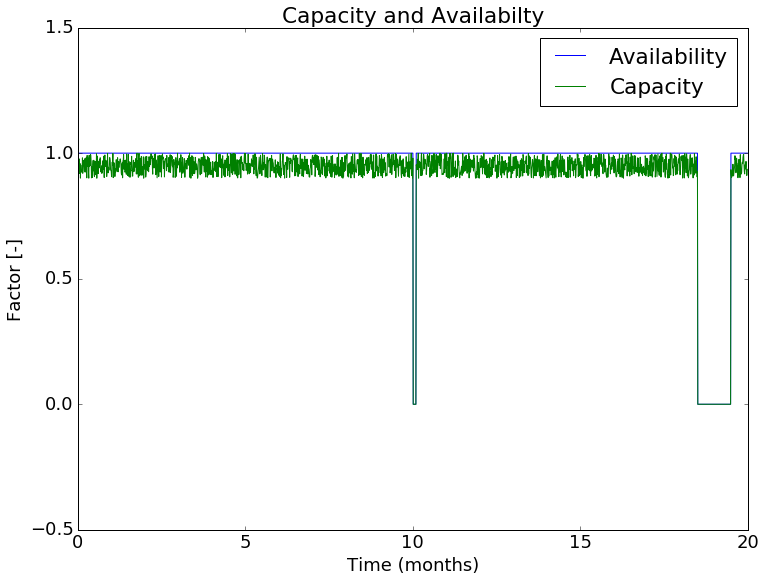

In [35]:
# The reactor shuts down:
# for a few days during the 10th month
# for one month during month 18
shutdowns = {10:10.1,
             18.5:19.5}

import numpy as np
def A(t, shutdowns):
    to_ret = 1.0*(t > 0)
    for start,stop in shutdowns.items():
        if start < t and t < stop:
            to_ret = 0
    return to_ret

times = np.arange(0.0, 20.0, 0.01)
hist = np.arange(0.0, 20.0, 0.01)
cf = np.arange(0.0, 20.0, 0.01)

for i in range(0, times.size):
    hist[i] = A(times[i], shutdowns)
    cf[i] = A(times[i], shutdowns)*(1.-0.1*np.random.random())
    
plt.plot(times, hist, label='Availability')
plt.plot(times, cf, label='Capacity')

plt.ylim([-0.5, 1.5])
plt.title('Capacity and Availabilty')
plt.xlabel('Time (months)')
plt.ylabel('Factor [-]')
plt.legend()


We can do a quick numeric integral to get each factor as an integral over the 20 month cycle.

\begin{align}
AF &= \frac{\int_0^{20}A(t)dt}{T}\\
CF &= \frac{\int_0^{20}P(t)dt}{P_0T}\\
\end{align}


In [36]:
print("Availability Factor = ", hist.sum()/hist.shape[0])
print("Capacity Factor = ", cf.sum()/cf.shape[0])

Availability Factor =  0.9455
Capacity Factor =  0.8975245452


## Simple Reactivity Model
- On each cycle (1/n)th of the fuel is replaced
- Each fuel batch experiences a discharge burnup of Bd
- Each fuel batch on each cycle experiences a burnup of Bd/n
- $k_{reactor}$ is the uncontrolled multiplication factor (excess reactivity)
- $k_i$ is the infinite multiplication factor of a fuel batch (excess reactivity)
    
Each batch of fuel will have a different burn-up and $k_i(B)$ since each batch has been in the reactor a different length of time. The reactivity of the reactor is found by summing over the reactivities of all the batches of fuel, for n batches:

\begin{align}
k_{reactor} = \frac{1}{n}\sum_{i=1}^{n}k_i(B)
\end{align}


\begin{align}
k_i(B) = k_0 - \alpha B_n
\end{align}

- $k_0$ is the uncontrolled infinite multiplication factor of the fuel batch when it is fresh.
- $B_n$ is the burnup of the batch in a single cycle. The n refers to the number of batches that the reload scheme includes.
- $\alpha$ is a constant of proportionality with units of 1/Bn. Uniform linear depletion.
- $k_F$ is the uncontrolled infinite multiplication factor necessary to sustain a chain reaction at the end of an operating cycle



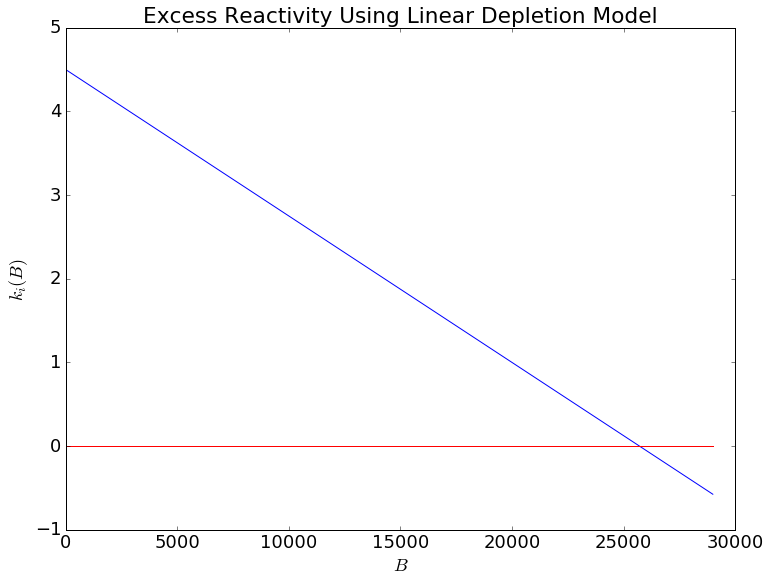

In [37]:

def ki(k0, alpha, b):
    return k0 - alpha*b

def k(ki, n):
    return (1/n)*np.sum(ki)

n=3
k0 = 4.5
alpha = (k0 - 1)/20000
bu = np.arange(0, 30000., 1000.)
plt.plot(bu, ki(k0, alpha, bu))
plt.plot(bu, np.zeros(bu.shape), color='r')
plt.ylabel(r'$k_i(B)$')
plt.xlabel(r'$B$')
plt.title('Excess Reactivity Using Linear Depletion Model')

This approximation is somewhat accurate and gives an intuition for the impact of reloading on excess reactivity in the core. 

![./reloading_keff.png](./reloading_keff.png)

## Single Cycle Refuelling


![./reload.png](./reload.png)

\begin{align}
k_{reactor} = k_1(B_1)
\end{align}


\begin{align}
k_1(B_1) = k_0 - \alpha B_1
\end{align}

Therefore the fuel burnup capability is:

\begin{align}
B_1 &= \frac{k_0-k_F}{\alpha}
\end{align}


## Two Cycle Refuelling

![./two_batch_reload.png](./two_batch_reload.png)

At the end of each cycle one batch of fuel has been burned for one cycle and the other batch has been burned for two cycles. Thus:

\begin{align}
k_F &= \frac{k_0 - \alpha B_2}{2} + \frac{k_0 - 2\alpha B_2}{2}\\
  &= k_0 - \frac{3\alpha B_2}{2}\\
B_2 &= \frac{2(k_0 - k_F)}{3\alpha}\\
    &= \frac{2}{3}B_1
\end{align}

- Each batch in the two cycle reload scheme is burned for $2B_2$. 

So, in terms of the single cycle reload burnup:

\begin{align}
2B_2 &= 2\left(\frac{2}{3}B_1\right)\\
     &= \frac{4}{3}B_1\\
\end{align}

**This means there is 1/3 more burnup in the two cycle reload, for the same initial and final multiplication factors $k_0$ and $k_F$ (exactly the same fuel.)**


## N Cycle Reload Scheme

The relation between end-of-cycle core multiplication factor kF and the fresh fuel batch infinite multiplication factor k0 and the batch burnup in general is


\begin{align}
k_F &= k_0 - \frac{1}{n}\sum_{i=1}^{n}i\alpha B_n\\
\end{align}

Recall from your geometric series intution:
\begin{align}
\sum_{i=1}^{n}i &= \frac{n(n + 1)}{2}\\
\end{align}

Therefore:

\begin{align}
k_F &= k_0 - \left(\frac{n + 1}{2}\right)\alpha B_n\\
\end{align}

The batch burnup in a single cycle is then the result of solving for $B_n$:

\begin{align}
B_n &= \frac{2(k_0 - k_F)}{\alpha(n + 1)}
\end{align}


The discharge burnup of batch n, is the batch burnup in a cycle times the number of cycles:

\begin{align}
B_n^d &= nB_n\\
&= \frac{2n(k_0 - k_F)}{\alpha(n + 1)}\\
      &= \left(\frac{2n}{n + 1}\right)\frac{k_0 - k_F}{\alpha} \\
 &= \left(\frac{2n}{n + 1}\right)B_1 \\
\end{align}


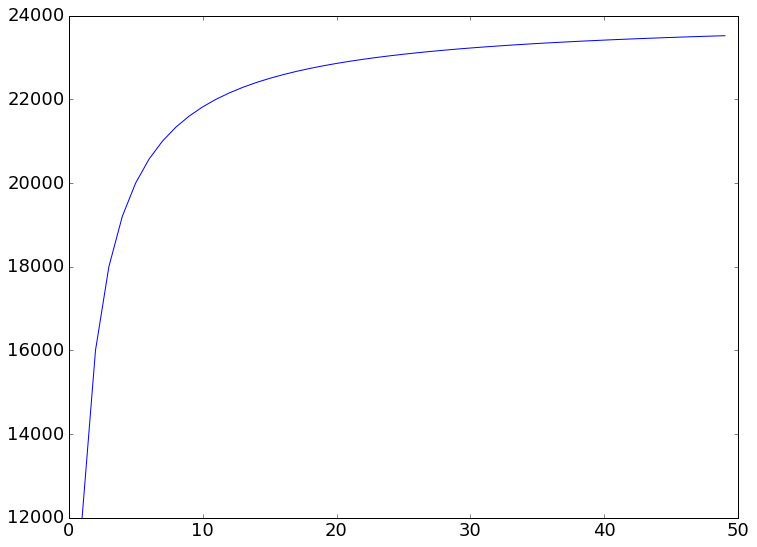

In [38]:
def bd(n, b1):
    num = 2*n*b1
    denom = n+1
    return num/denom

b1 = 12000
n = np.arange(1,50)
plt.plot(n, bd(n, b1))

## Fuel Loading Patterns  

## Many and $\infty$ Batch Reactor Designs


## Extended Burnup

## Determining Burnup